## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets
from ronald_bdl.models import utils

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Length scale
length_scale = 1e-2

# tau
tau = 0.25

# reg strength
reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))

# Epochs
n_epochs = 400

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

reg_strength = tensor(9.0000e-06)


### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low-5, dataset_toy_x_high+5, 100).reshape(100, 1)

y_test = torch.pow(X_test, 3)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

y_test = y_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout_relu'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )
    
    uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='tanh',
    )
    
    uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='sigmoid',
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout_relu
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 565.0865
[iteration 0101] loss: 351.0674
[iteration 0201] loss: 244.6162
[iteration 0301] loss: 168.8836
final loss = tensor(191.0298, grad_fn=<MseLossBackward>)
training time = 1.5266938209533691 seconds

Now running mc_dropout_tanh
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): Tanh()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 588.6322
[iteration 0101] loss: 411.6652
[iteration 0201] loss: 318.1104
[

## Plot the results

/Users/se9/Documents/git/bayesian-dl-experiments/ronald_bdl/models/fcnet.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reg_strength = torch.tensor(
/Users/se9/Documents/git/bayesian-dl-experiments/ronald_bdl/models/fcnet.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(


testing time = 0.5060639381408691 seconds

Mean = tensor([-63.6620, -63.4631, -59.5067, -59.5910, -59.4108, -57.0985, -56.0169,
        -54.6594, -52.6764, -52.6779, -49.7709, -49.6637, -48.5998, -47.9490,
        -47.7857, -44.3594, -43.9736, -42.7731, -41.5203, -40.0172, -38.9487,
        -37.8885, -35.6980, -35.0081, -33.2706, -32.1586, -31.0053, -30.1104,
        -28.8503, -27.0577, -25.9164, -24.5119, -23.2865, -22.2530, -20.9244,
        -19.3088, -17.7456, -16.9369, -15.2629, -14.0485, -12.7313, -11.1138,
        -10.0544,  -8.4446,  -7.1042,  -5.5543,  -4.0472,  -2.3946,  -0.7561,
          0.7560,   2.2816,   3.7880,   5.3088,   6.6260,   7.9596,   9.0752,
         10.3141,  11.5274,  12.9049,  14.0644,  15.3274,  16.5796,  17.8264,
         19.1518,  20.6238,  21.9669,  23.3553,  24.4891,  25.5957,  27.1136,
         28.4772,  29.5986,  30.7133,  31.7385,  33.5027,  34.0450,  35.5266,
         36.5929,  37.4462,  39.3907,  40.6543,  42.1427,  42.9946,  44.2342,
         44.96

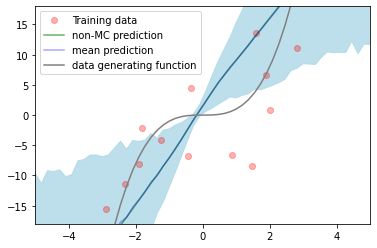

testing time = 0.7467978000640869 seconds

Mean = tensor([-22.9237, -22.8057, -22.6939, -22.0604, -22.8956, -22.6951, -22.1249,
        -22.7959, -22.6026, -22.9045, -22.8483, -22.7257, -22.8590, -22.2465,
        -22.3184, -22.6828, -22.1622, -22.1360, -22.3288, -22.2487, -22.0841,
        -21.7518, -21.6794, -22.0454, -21.9198, -21.4590, -21.2598, -20.9923,
        -20.5361, -20.9436, -20.0576, -19.4394, -19.4578, -18.5921, -17.9966,
        -17.5667, -16.8412, -15.2372, -14.6197, -13.4731, -11.7302, -10.6935,
         -9.3720,  -7.7057,  -6.3467,  -4.8267,  -3.3880,  -1.9144,  -0.4796,
          0.9545,   2.3304,   3.7053,   4.9994,   6.2549,   7.4656,   8.6839,
          9.7273,  11.0112,  12.0977,  13.0514,  14.3070,  15.1825,  15.7136,
         16.7606,  17.3054,  18.1799,  18.7988,  19.2870,  19.7433,  20.1764,
         21.0764,  20.8638,  21.1993,  21.6904,  21.7693,  21.8053,  21.9978,
         22.0104,  22.5762,  21.9751,  22.3100,  22.6330,  22.8412,  23.1806,
         22.67

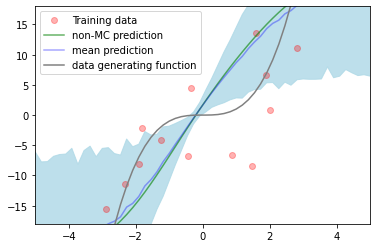

testing time = 0.5820808410644531 seconds

Mean = tensor([-13.9617, -14.1379, -13.8388, -14.3034, -14.0824, -14.1752, -14.1359,
        -14.0752, -13.9487, -13.9053, -14.2850, -13.7991, -14.1237, -13.7239,
        -13.8648, -14.0582, -13.7614, -13.5366, -13.6758, -13.6841, -13.5459,
        -13.5922, -13.6503, -13.4640, -13.3712, -13.4260, -13.1227, -13.2814,
        -12.6994, -12.7276, -12.5885, -12.3090, -12.1245, -12.0244, -11.3075,
        -11.3213, -10.8367, -10.5842,  -9.9871,  -9.2381,  -8.8623,  -8.0101,
         -7.2165,  -6.5730,  -5.5032,  -4.3759,  -3.3961,  -2.2417,  -1.0164,
          0.2097,   1.4889,   2.6518,   3.8762,   5.0761,   6.0980,   7.1531,
          8.2186,   9.0990,   9.6527,  10.8055,  11.6133,  11.8186,  12.4400,
         12.9031,  13.2233,  13.5942,  14.0092,  14.3467,  14.4876,  14.9785,
         15.1664,  15.1273,  15.5120,  15.9077,  15.8286,  16.0518,  15.9946,
         15.9760,  16.2478,  16.2731,  16.4224,  16.4261,  16.5307,  16.3396,
         16.29

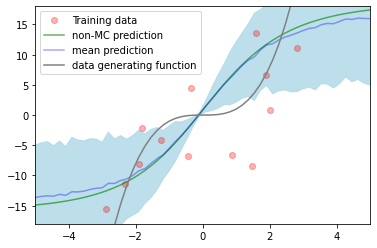

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(
        X_test, n_predictions, y_test=y_test, reg_strength=reg_strength, train_size=dataset_toy_size)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for metric_key, value in metrics.items():
            print(str(metric_key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low-1, dataset_toy_x_high+1)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()